# 1 Motivação

O objetivo principal deste projeto foi desenvolver uma Convolutional Neural Network (CNN) baseada na arquitetura LeNet, uma das precursoras na área da visão computacional, com o intuito de avaliar sua eficácia na classificação de imagens. Para realizar essa avaliação, utilizei dois conjuntos de dados amplamente reconhecidos na academia: [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) e [SVHN (Street View House Numbers)](https://www.tensorflow.org/datasets/catalog/svhn_cropped).

Para tornar o experimento mais próximo de situações reais, simulei a presença de ruído gaussiano nas imagens durante o processo de treinamento, refletindo a diversidade de fontes e condições de captura de imagens na vida real. Isto é, câmeras diferentes possuem resoluções variadas.

Ao final, examinei o impacto dessa estratégia na performance dos modelos, buscando insights valiosos para aplicações práticas de redes neurais convolucionais em ambientes variados e desafiadores.

# 2 Implementação

Import das bibliotecas utilizadas

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from skimage.util import random_noise
import scipy.io
from sklearn.metrics import accuracy_score
import pickle
from sklearn.metrics import accuracy_score

## 2.1 Criando a CNN

Arquitetura utilizada é uma simplificação da estrutura [LeNet](https://en.wikipedia.org/wiki/LeNet), originalmente proposta por Yann LeCun em 1998,  projetada para reconhecimento de dígitos manuscritos.

A estrutura básica da LeNet consiste em camadas convolucionais intercaladas com camadas de subamostragem (pooling) seguidas por camadas densas para classificação.

Podemos resumir a arquitetura implementada pelas seguintes etapas:

1. Camada de entrada: A entrada é uma imagem com dimensões 32x32x3, onde 3 representa os canais RGB.

2. Camadas Convolucionais e MaxPooling: A estrutura segue um padrão de camadas convolucionais seguidas por camadas de max-pooling. Cada camada convolucional usa um kernel de tamanho 3x3, com ativação ReLU e preenchimento ('same') para manter as mesmas dimensões da entrada. Em seguida, uma camada de max-pooling com um pool size de 2x2 é aplicada para reduzir a dimensionalidade.

3. Flatten Layer: Após as camadas convolucionais e de max-pooling, a camada Flatten é utilizada para converter o tensor tridimensional resultante em um vetor unidimensional, preparando-o para as camadas densas.

4. Camada Densa (Fully Connected): A última camada é uma camada densa com 10 neurônios e ativação softmax, que representa a probabilidade da imagem avaliada pertencer a cada uma das 10 classes presentes nos datasets propostos.

In [ ]:
model = tf.keras.models.Sequential()
# Conv2D: 16 neurônios (filters), kernels 3x3, ReLU
# MaxPooling2D: pool 2x2
model.add(tf.keras.layers.Conv2D(16, kernel_size=(3, 3), activation ='relu', padding='same', input_shape=(32,32,3)))
model.add(tf.keras.layers.MaxPooling2D(pool_size =(2, 2)))
# Conv2D: 16 neurônios (filters), kernels 3x3, ReLU
# Conv2D: 16 neurônios (filters), kernels 3x3, ReLU
# MaxPooling2D: pool 2x2
model.add(tf.keras.layers.Conv2D(16, kernel_size=(3, 3), activation ='relu', padding='same'))
model.add(tf.keras.layers.Conv2D(16, kernel_size=(3, 3), activation ='relu', padding='same'))
model.add(tf.keras.layers.MaxPooling2D(pool_size =(2, 2)))
# Conv2D: 32 neurônios (filters), kernels 3x3, ReLU
# Conv2D: 32 neurônios (filters), kernels 3x3, ReLU
# MaxPooling2D: pool 2x2
model.add(tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation ='relu', padding='same'))
model.add(tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation ='relu', padding='same'))
model.add(tf.keras.layers.MaxPooling2D(pool_size =(2, 2)))
# Camada do tipo Flatten para transformar o output do terceiro maxpooling (que será um tensor) em um vetor
model.add(tf.keras.layers.Flatten())
# Dense: 10 neurônios
model.add(tf.keras.layers.Dense(10, activation='softmax'))
# escolha da função softmax pois se trata se um problema de classificação multiclasse

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 16)        2320      
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 16)        2320      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 8, 8, 16)          0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 32)          4

Explicando algumas decisões sobre a arquitetura:

* Padding
 * O parâmetro `padding='same`' controla como o preenchimento é aplicado às bordas da entrada durante a convolução. Quando padding='same' é utilizado, a entrada é preenchida de tal forma que a saída da convolução tem as mesmas dimensões que a entrada original.

    Em termos práticos, isso mantém a resolução espacial da entrada através das camadas convolucionais, o que ajuda a evitar a perda de informações nas bordas das imagens durante as operações de convolução.

* Camadas iniciais com 16 neurônios e camadas finais com 32.
 * Em uma CNN, as camadas iniciais são responsáveis pela detecção de características de baixo nível, como bordas, texturas simples, e padrões simples de cores. À medida que avançamos nas camadas da rede, as características extraídas se tornam gradualmente mais complexas e abstratas, representando características de nível superior, como formas, partes de objetos e até mesmo objetos inteiros.
  
    A variação no número de neurônios permite que a rede aprenda e represente essas características em diferentes níveis de abstração. À medida que o número de neurônios aumenta nas camadas posteriores, a rede é capaz de capturar padrões mais complexos.

* ReLu
  * Sua forma simples e de fácil compreensão, $f(x) = max(0, x)$, permite uma computação eficiente e rápida, o que é vantajoso durante o treinamento da rede em grandes conjuntos de dados. A função ReLU também é menos suscetível ao problema de desvanecimento do gradiente em comparação com funções de ativação como sigmoid e tanh. Isso ocorre porque a derivada da ReLU é 1 para valores positivos e 0 para valores negativos, evitando a diminuição do gradiente durante a retropropagação em camadas profundas da rede.

## 2.2 Carregamento e processamento das bases de dados


Ajuste das dimensões dos para a rede e quebra dos conjuntos de treinamento e teste.
Base desenvolvida pelo *Canadian Institute For Advanced Research*.

Código de extração oriundo da [documentação do pacote Keras](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/cifar10/load_data)

In [ ]:
(cifar10_x_train, cifar10_y_train), (cifar10_x_test, cifar10_y_test) = tf.keras.datasets.cifar10.load_data()
assert cifar10_x_train.shape == (50000, 32, 32, 3)
assert cifar10_x_test.shape == (10000, 32, 32, 3)
assert cifar10_y_train.shape == (50000, 1)
assert cifar10_y_test.shape == (10000, 1)

170498071/170498071 [==============================] - 7s 0us/step


In [ ]:
cifar10_y_train = cifar10_y_train.reshape(-1)
cifar10_y_test = cifar10_y_test.reshape(-1)

cifar10_y_train.shape, cifar10_y_test.shape

((50000,), (10000,))

Base de dados disponivel no site da [Universidade de Stanford](http://ufldl.stanford.edu/housenumbers/). O formato original no momento da análise era de .mat típico da ferramenta Matlab. Neste caso X_train e X_test estão com as dimensões em uma ordem diferente da utilizada no padrão do pacote Keras. As bases foram ajustadas para formato (id da imagem, linhas, colunas e
canais);


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import scipy.io
train_matrix = scipy.io.loadmat('/content/train_32x32.mat')
test_matrix = scipy.io.loadmat('/content/test_32x32.mat')

train_matrix.keys(), test_matrix.keys()

(dict_keys(['__header__', '__version__', '__globals__', 'X', 'y']),
 dict_keys(['__header__', '__version__', '__globals__', 'X', 'y']))

In [ ]:
svhn_x_train = train_matrix['X']
svhn_y_train = train_matrix['y']
svhn_x_test = test_matrix['X']
svhn_y_test = test_matrix['y']


svhn_x_train.shape, svhn_x_test.shape,  svhn_y_train.shape, svhn_y_test.shape

((32, 32, 3, 73257), (32, 32, 3, 26032), (73257, 1), (26032, 1))

In [ ]:
# ajustanto as dimensões (id da imagem, linhas, colunas e canais)
svhn_x_train = np.transpose(svhn_x_train, (3, 0, 1, 2))
svhn_x_test = np.transpose(svhn_x_test, (3, 0, 1, 2))

svhn_x_train.shape, svhn_x_test.shape

((73257, 32, 32, 3), (26032, 32, 32, 3))

In [ ]:
svhn_y_train = svhn_y_train.reshape(-1)
svhn_y_test = svhn_y_test.reshape(-1)

svhn_y_train.shape, svhn_y_test.shape

((73257,), (26032,))

Convertendo os tipos de dados para obter redução no consumo de memória RAM e acelerar o processo de aprendizado.
Foram feitas as transformações:
* Converter as imagens (X_train e X_test) para float16.
* Converter as classes (y_train e y_test) para uint8.

In [ ]:
cifar10_x_train = cifar10_x_train.astype('float16')
cifar10_x_test = cifar10_x_test.astype('float16')


cifar10_y_train = cifar10_y_train.astype('uint8')
cifar10_y_test = cifar10_y_test.astype('uint8')


In [ ]:
svhn_x_train = svhn_x_train.astype('float16')
svhn_x_test = svhn_x_test.astype('float16')

svhn_y_train = svhn_y_train.astype('uint8')
svhn_y_test = svhn_y_test.astype('uint8')

Normalização dos Dados:

A normalização dos dados para o intervalo [0; 1] ajuda a garantir que todos os valores dos pixels das imagens estejam na mesma escala. Isso facilita o treinamento da CNN, pois evita que existam entradas que tenham uma escala muito maior do que as demais, o que poderia afetar negativamente o processo de otimização.


Além disso a normalização por auxiliar na estabilidade do treinamento. Isso ocorre porque a utilização de valores menores ajuda a reduzir a probabilidade de saturação das funções de ativação e facilita o fluxo de gradientes durante a retropropagação.

In [ ]:
# Cifar 10
cifar10_x_train = cifar10_x_train/255
cifar10_x_test = cifar10_x_test/255

cifar10_x_train[0, 0, :5], cifar10_x_test[0, 0, :5]

(array([[0.2313, 0.2432, 0.2471],
        [0.1686, 0.1804, 0.1765],
        [0.196 , 0.1882, 0.1686],
        [0.2666, 0.2118, 0.1647],
        [0.3843, 0.2864, 0.204 ]], dtype=float16),
 array([[0.6196, 0.4392, 0.1921],
        [0.6235, 0.4353, 0.1843],
        [0.647 , 0.4548, 0.2   ],
        [0.651 , 0.4626, 0.2079],
        [0.6274, 0.4392, 0.1804]], dtype=float16))

In [ ]:
np.max(cifar10_x_train), np.max(cifar10_x_test), np.min(cifar10_x_train), np.min(cifar10_x_test)

(1.0, 1.0, 0.0, 0.0)

In [ ]:
# SVHN
svhn_x_train = svhn_x_train/255
svhn_x_test = svhn_x_test/255

svhn_x_train[0, 0, :5], svhn_x_test[0, 0, :5]

(array([[0.1294 , 0.1177 , 0.149  ],
        [0.05884, 0.0902 , 0.0745 ],
        [0.05884, 0.06665, 0.0745 ],
        [0.1647 , 0.1726 , 0.1726 ],
        [0.2627 , 0.251  , 0.2118 ]], dtype=float16),
 array([[0.149 , 0.4038, 0.2354],
        [0.153 , 0.408 , 0.2393],
        [0.153 , 0.408 , 0.2432],
        [0.1608, 0.408 , 0.2471],
        [0.1686, 0.4038, 0.251 ]], dtype=float16))

In [ ]:
np.max(svhn_x_train), np.max(svhn_x_test), np.min(svhn_x_train), np.min(svhn_x_test)

(1.0, 1.0, 0.0, 0.0)

In [ ]:
cifar10_x_train.dtype

dtype('float16')

Avaliando a distribuição das classes nos conjuntos:

In [ ]:
# Cifar 10
print(f'Qtd. de imagens de treino CIFAR 10:: {cifar10_x_train.shape[0]}')
print(f'Qtd. de imagens de test CIFAR 10:: {cifar10_x_test.shape[0]}')

print(f'Número de linhas:: {cifar10_x_train.shape[1]}')
print(f'Número de colunas:: {cifar10_x_train.shape[2]}')
print(f'Número de canais:: {cifar10_x_train.shape[3]}')

Qtd. de imagens de treino CIFAR 10:: 50000
Qtd. de imagens de test CIFAR 10:: 10000
Número de linhas:: 32
Número de colunas:: 32
Número de canais:: 3


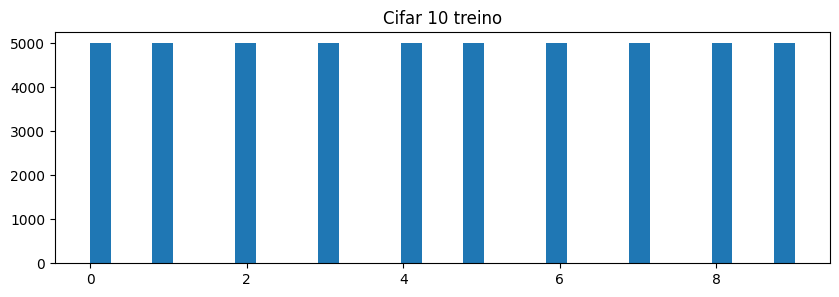

In [ ]:
# Distribuição das classes no treinamento
plt.figure(figsize=(10, 3))
_ = plt.hist(cifar10_y_train, bins='auto')
plt.title("Cifar 10 treino")

plt.show()

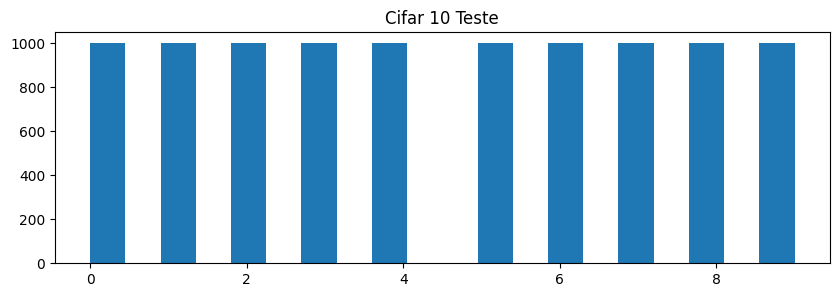

In [ ]:
# Distribuição das classes no test
plt.figure(figsize=(10, 3))
_ = plt.hist(cifar10_y_test, bins='auto')
plt.title("Cifar 10 Teste")

plt.show()

In [ ]:
# SVHN
print(f'Qtd. de imagens de treino SVHN:: {svhn_x_train.shape[0]}')
print(f'Qtd. de imagens de test SVHN:: {svhn_x_test.shape[0]}')

print(f'Número de linhas:: {svhn_x_train.shape[1]}')
print(f'Número de colunas:: {svhn_x_train.shape[2]}')
print(f'Número de canais:: {svhn_x_train.shape[3]}')

Qtd. de imagens de treino SVHN:: 73257
Qtd. de imagens de test SVHN:: 26032
Número de linhas:: 32
Número de colunas:: 32
Número de canais:: 3


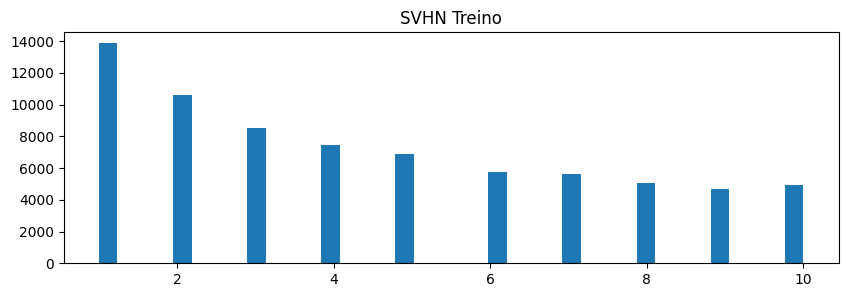

In [ ]:
# Distribuição das classes no treinamento
plt.figure(figsize=(10, 3))
_ = plt.hist(svhn_y_train, bins='auto')
plt.title("SVHN Treino")

plt.show()

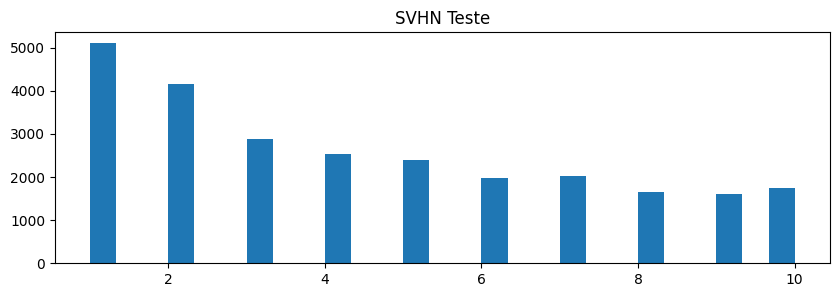

In [ ]:
# Distribuição das classes no test
plt.figure(figsize=(10, 3))
_ = plt.hist(svhn_y_test, bins='auto')
plt.title("SVHN Teste")

plt.show()

Podemos ver pelos histogramas gerados acima que a base de cados Cifar 10 tem suas classes com uma distribuição mais uniforme, enquanto que a base de SVHN posui uma concentração de números menores.

## 2.3 Inserção de Ruído Gaussiano

Uma técnica eficaz para aumentar a capacidade de modelos de reconhecimento de imagens é a inserção de ruídos aleatórios nas imagens. Esses "ruídos" são pequenas perturbações adicionadas aos valores dos pixels, utilizando uma distribuição de probabilidade conhecida, como a distribuição normal (Gaussiana).

Ao adicionar ruído às imagens durante o treinamento, efetivamente aumentamos a diversidade dos dados de treinamento, o que pode melhorar a capacidade do modelo de generalizar para novas imagens. Além disso, essa abordagem torna o treinamento mais robusto, preparando o modelo para lidar com as variações e imperfeições presentes em imagens do mundo real, capturadas por diferentes dispositivos e em diferentes condições de iluminação e resolução.

No entanto, é importante ter cautela ao adicionar ruído, pois um excesso pode prejudicar a capacidade do modelo de reconhecer os padrões relevantes nas imagens. Não existe uma quantidade "mágica" de ruído que funcione para todos os casos. É necessário realizar experimentos e ajustes para determinar a quantidade ideal de ruído e garantir que o modelo seja treinado de maneira eficaz.

---

Neste projeto geramos duas versões nas duas bases de dados, com a utilização de sinais com variâncias de 0.001 e 0.01, respectivamente.

In [ ]:
# criando dicionário com os dados
cifar10_data = {
    'train' : cifar10_x_train,
    'test' : cifar10_x_test
}


cifar10_data['train_noise_0001'] = random_noise(cifar10_x_train, mode='gaussian', var=0.001).astype('float16')
cifar10_data['test_noise_0001'] = random_noise(cifar10_x_test, mode='gaussian', var=0.001).astype('float16')

cifar10_data['train_noise_001'] = random_noise(cifar10_x_train, mode='gaussian', var=0.01).astype('float16')
cifar10_data['test_noise_001'] = random_noise(cifar10_x_test, mode='gaussian', var=0.01).astype('float16')


In [ ]:
svhn_data = {
    'train' : svhn_x_train,
    'test' : svhn_x_test
}

svhn_data['train_noise_0001'] = random_noise(svhn_x_train, mode='gaussian', var=0.001).astype('float16')
svhn_data['test_noise_0001'] = random_noise(svhn_x_test, mode='gaussian', var=0.001).astype('float16')

svhn_data['train_noise_001'] = random_noise(svhn_x_train, mode='gaussian', var=0.01).astype('float16')
svhn_data['test_noise_001'] = random_noise(svhn_x_test, mode='gaussian', var=0.01).astype('float16')


In [ ]:
# dicionario de significado das classe da cifar 10
# fonte : https://www.tensorflow.org/api_docs/python/tf/keras/datasets/cifar10/load_data
classes_dict = {
    0:'airplane',
1:'automobile',
2:'bird',
3:'cat',
4:'deer',
5:'dog',
6:'frog',
7:'horse',
8:'ship',
9:'truck'
}

In [ ]:
# lista do index do primeiro representando de cada classe na base de treino
imgs_idxs = [ np.where(cifar10_y_train == x)[0][0] for x in range(0, 10)]

images_list = [cifar10_data['train'][idx, :, :].astype('float32') for idx in imgs_idxs ]
images001_list = [cifar10_data['train_noise_001'][idx, :, :].astype('float32') for idx in imgs_idxs ]
images0001_list = [cifar10_data['train_noise_0001'][idx, :, :].astype('float32') for idx in imgs_idxs ]

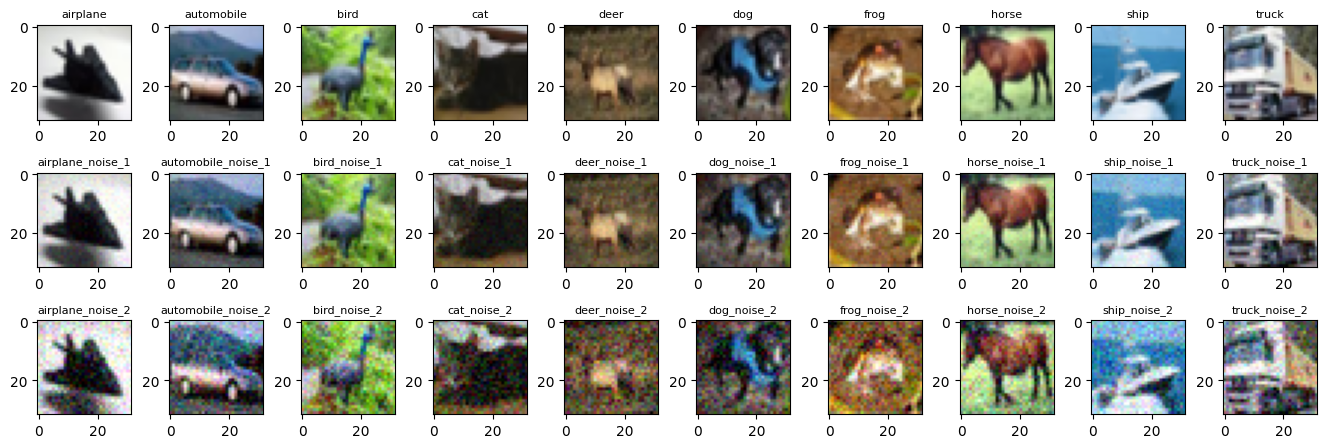

In [ ]:

f, axes = plt.subplots(3, len(imgs_idxs), figsize=(16, 5))

dict_imges = {0:images_list, 1:images0001_list, 2:images001_list}

dict_labels = {0:'', 1:'_noise_1', 2:'_noise_2'}

for row in range(3):
  for col in range(10):
    axes[row, col].imshow(dict_imges[row][col])
    axes[row, col].set_title(classes_dict[col]+dict_labels[row], size=8)
    col+=1

# set the spacing between subplots
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)
plt.show()

In [ ]:
# dicionario de significado das classe da svhn
# fonte : http://ufldl.stanford.edu/housenumbers/
classes_dict = {
  1:'1',
  2:'2',
  3:'3',
  4:'4',
  5:'5',
  6:'6',
  7:'7',
  8:'8',
  9:'9',
  10:'0'
}

In [ ]:
# lista do index do primeiro representando de cada classe na base de treino
imgs_idxs = [ np.where(svhn_y_train == x)[0][0] for x in range(1, 11)]

images_list = [svhn_data['train'][idx, :, :].astype('float32') for idx in imgs_idxs ]
images001_list = [svhn_data['train_noise_001'][idx, :, :].astype('float32') for idx in imgs_idxs ]
images0001_list = [svhn_data['train_noise_0001'][idx, :, :].astype('float32') for idx in imgs_idxs ]



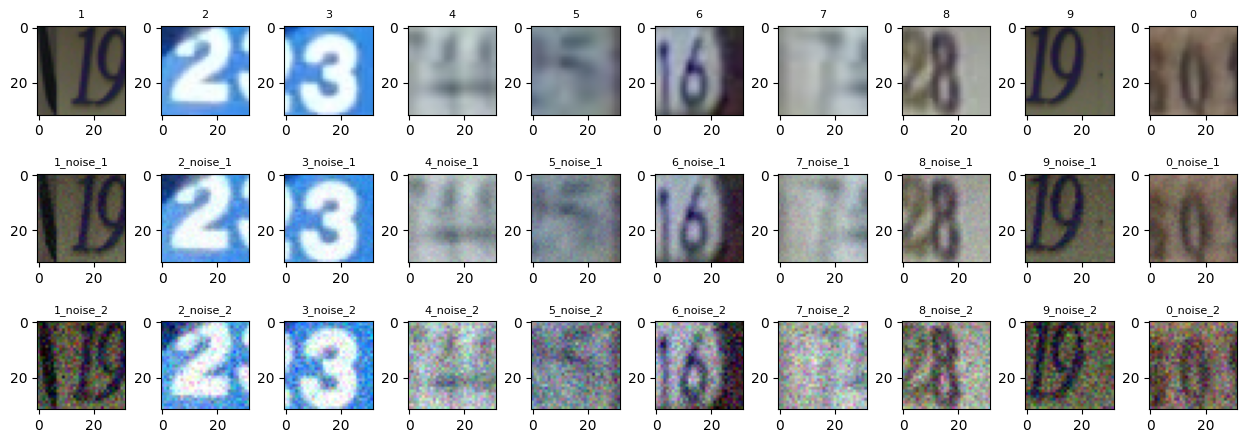

In [ ]:

f, axes = plt.subplots(3, len(imgs_idxs), figsize=(15, 5))
dict_imges = {0:images_list, 1:images0001_list, 2:images001_list}
dict_labels = {0:'', 1:'_noise_1', 2:'_noise_2'}
for row in range(3):
  for col in range(10):
    axes[row, col].imshow(dict_imges[row][col])
    axes[row, col].set_title(classes_dict[col+1]+dict_labels[row], size=8)
    col+=1

# set the spacing between subplots
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)
plt.show()

## 2.4 Treinamento dos Modelos

Foi treinada um modelo para cada versão das bases de dados. Isto é, foram gerados 6 modelos.

Todos os modelos foram treinados usando:
* Adam como otimizador;
* Por 10 épocas;
* Os demais parâmetros foram deixados com o padrão dos métodos do pacote Keras.

Temos para cada base 3 variações
normal - ruido1 (0.001) - ruido 2 (0.01)

Iremos treinar um modelo para cada variação da base (3) e para cada modelo testar com cada uma das versões dos dados de teste (3). Ao final para cada base teremos (3x3) 9 dados de comparação.

In [ ]:
def cria_modelo():
  """
  Cria um modelo de rede neural convolucional para classificação de imagens seguindo estrutura definida neste projeto.

  Retorna:
      model: Um modelo sequencial do Keras com a arquitetura especificada.
          A arquitetura consiste em camadas de convolução, max pooling e uma camada densa no final
          para classificação em 10 classes usando a função de ativação softmax.

  Exemplo:
      >>> modelo = cria_modelo()
  """

  model = tf.keras.models.Sequential()
  # Conv2D: 16 neurônios (filters), kernels 3x3, ReLU
  # MaxPooling2D: pool 2x2
  model.add(tf.keras.layers.Conv2D(16, kernel_size=(3, 3), activation ='relu', padding='same', input_shape=(32,32,3)))
  model.add(tf.keras.layers.MaxPooling2D(pool_size =(2, 2)))
  # Conv2D: 16 neurônios (filters), kernels 3x3, ReLU
  # Conv2D: 16 neurônios (filters), kernels 3x3, ReLU
  # MaxPooling2D: pool 2x2
  model.add(tf.keras.layers.Conv2D(16, kernel_size=(3, 3), activation ='relu', padding='same'))
  model.add(tf.keras.layers.Conv2D(16, kernel_size=(3, 3), activation ='relu', padding='same'))
  model.add(tf.keras.layers.MaxPooling2D(pool_size =(2, 2)))
  # Conv2D: 32 neurônios (filters), kernels 3x3, ReLU
  # Conv2D: 32 neurônios (filters), kernels 3x3, ReLU
  # MaxPooling2D: pool 2x2
  model.add(tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation ='relu', padding='same'))
  model.add(tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation ='relu', padding='same'))
  model.add(tf.keras.layers.MaxPooling2D(pool_size =(2, 2)))
  # Dica: Use uma camada do tipo Flatten para transformar o output do terceiro maxpooling (que será um tensor) em um vetor
  model.add(tf.keras.layers.Flatten())
  # Dense: 10 neurônios
  model.add(tf.keras.layers.Dense(10, activation='softmax'))

  return model


In [ ]:
def execucao_do_modelo(model, x_train, y_train, loss_function='sparse_categorical_crossentropy', n_epochs=10, eval_metrics=['accuracy']):
  """
  Executa o treinamento de um modelo de rede neural.

  Args:
      model (tf.keras.Model): O modelo de rede neural a ser treinado.
      x_train (numpy.ndarray): O conjunto de dados de treinamento.
      y_train (numpy.ndarray): A variável resposta do conjunto de dados de treinamento.
      loss_function (str, optional): A função de perda utilizada para direcionar a otimização do modelo.
          Padrão é 'sparse_categorical_crossentropy'.
      n_epochs (int, optional): O número de épocas de treinamento. Padrão é 10.
      eval_metrics (list of str, optional): As métricas de avaliação das épocas de treinamento.
          Padrão é ['accuracy'].

  Returns:
      tf.keras.callbacks.History: O objeto History contendo informações sobre a evolução das métricas
          através das épocas de treinamento.

  Notes:
      A escolha da função de perda é baseada nas recomendações do artigo:
      'https://machinelearningmastery.com/how-to-choose-loss-functions-when-training-deep-learning-neural-networks/'.

      A métrica e o otimizador são definidos conforme exigências do projeto antes do treinamento do modelo.

  Example:
      >>> history = execucao_do_modelo(model, x_train, y_train)
  """
  # escolha da função baseado no artigo https://machinelearningmastery.com/how-to-choose-loss-functions-when-training-deep-learning-neural-networks/

  # métrica e otimizador definios segundo exigências do projeto
  model.compile(optimizer='adam', loss=loss_function, metrics=eval_metrics)

  # registro da evolução das métricas através das épocas de treinamento
  historico_de_execucao = model.fit(x=x_train, y=y_train, epochs=n_epochs)


  return historico_de_execucao



In [ ]:
def avaliar_modelo(dados, y_train):
    """
    Avalia o modelo de rede neural em diferentes combinações de conjuntos de treinamento e teste.

    Args:
        dados (dict): Um dicionário contendo as diferentes variações do conjunto de treinamento
            e do conjunto de teste. As chaves devem ser 'train', 'train_noise_001', 'train_noise_0001',
            'test', 'test_noise_001' e 'test_noise_0001', representando as diferentes combinações de dados.
        y_train (numpy.ndarray): A variável resposta do conjunto de treinamento.

    Returns:
        dict: Um dicionário contendo os resultados do treinamento e da avaliação do modelo para cada
            combinação de conjunto de treinamento e teste. Cada chave no dicionário corresponde a uma
            variação do conjunto de treinamento.

    Notes:
        Esta função cria uma nova instância do modelo para cada combinação de conjunto de treinamento e teste,
        a fim de evitar que os pesos e vieses de um treinamento interfiram no seguinte.

    Example:
        >>> resultados = avaliar_modelo(cifar10_data, cifar10_y_train)
    """
    resultados = {}
    keys_treino = [x for x in dados.keys() if 'train' in x]
    keys_teste = [x for x in dados.keys() if 'test' in x]

    # para cada dado de treino executar em uma versão dos dados de teste
    for treino in keys_treino:
      # criando nova instancia do modelo para evitar que os pesos e viéses de um treinamento interfiram no seguinte
      modelo = cria_modelo()
      historico = execucao_do_modelo(modelo, dados[treino], y_train)
      resultados[treino] = {'historico': historico}

      for idx, teste in enumerate(keys_teste):
        # predict retorna as probablilidades de cada classe - queremos sempre a mais provável
        resultados[treino]['y_pred_'+str(idx)] = np.argmax(modelo.predict(dados[teste]).astype('float16'), axis=1).astype('uint8')

    return resultados

In [ ]:
cifar10_resultados = avaliar_modelo(cifar10_data, cifar10_y_train)

Epoch 1/10
1563/1563 [==============================] - 16s 9ms/step - loss: 1.5394 - accuracy: 0.4438
Epoch 2/10
1563/1563 [==============================] - 15s 9ms/step - loss: 1.1944 - accuracy: 0.5764
Epoch 3/10
1563/1563 [==============================] - 8s 5ms/step - loss: 1.0530 - accuracy: 0.6302
Epoch 4/10
1563/1563 [==============================] - 8s 5ms/step - loss: 0.9549 - accuracy: 0.6659
Epoch 5/10
1563/1563 [==============================] - 9s 6ms/step - loss: 0.8943 - accuracy: 0.6886
Epoch 6/10
1563/1563 [==============================] - 9s 5ms/step - loss: 0.8453 - accuracy: 0.7067
Epoch 7/10
1563/1563 [==============================] - 9s 6ms/step - loss: 0.8079 - accuracy: 0.7174
Epoch 8/10
1563/1563 [==============================] - 11s 7ms/step - loss: 0.7752 - accuracy: 0.7274
Epoch 9/10
1563/1563 [==============================] - 9s 6ms/step - loss: 0.7471 - accuracy: 0.7388
Epoch 10/10
313/313 [==============================] - 1s 3ms/step
Epoch 1/10
1

In [ ]:
# a funçao 'sparse_categorical_crossentropy' precisa receber valores no intervalo [0, 10)
# para isso resetar as classes - fazendo 10 ser zero, como já é descrito em : http://ufldl.stanford.edu/housenumbers/
# '10 classes, 1 for each digit. Digit '1' has label 1, '9' has label 9 and '0' has label 10.'
svhn_y_train[svhn_y_train==10] = 0
svhn_y_test[svhn_y_test==10] = 0

svhn_resultados = avaliar_modelo(svhn_data, svhn_y_train)

Epoch 1/10
2290/2290 [==============================] - 16s 6ms/step - loss: 0.8553 - accuracy: 0.7277
Epoch 2/10
2290/2290 [==============================] - 12s 5ms/step - loss: 0.4483 - accuracy: 0.8663
Epoch 3/10
2290/2290 [==============================] - 12s 5ms/step - loss: 0.3759 - accuracy: 0.8890
Epoch 4/10
2290/2290 [==============================] - 13s 5ms/step - loss: 0.3330 - accuracy: 0.9016
Epoch 5/10
2290/2290 [==============================] - 12s 5ms/step - loss: 0.3068 - accuracy: 0.9089
Epoch 6/10
2290/2290 [==============================] - 12s 5ms/step - loss: 0.2863 - accuracy: 0.9157
Epoch 7/10
2290/2290 [==============================] - 12s 5ms/step - loss: 0.2719 - accuracy: 0.9193
Epoch 8/10
2290/2290 [==============================] - 13s 5ms/step - loss: 0.2577 - accuracy: 0.9234
Epoch 9/10
2290/2290 [==============================] - 12s 5ms/step - loss: 0.2446 - accuracy: 0.9272
Epoch 10/10
814/814 [==============================] - 2s 2ms/step
Epoch 

Escrita dos resultados em arquivo .pickle para pode acessar mais facilmente os resultados sem ter que passar todas as vezes pelo processo de treino das bases.

In [ ]:
with open('resultados_execucao_cifar10.p', 'wb') as fp:
    pickle.dump(cifar10_resultados, fp, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
with open('resultados_execucao_svhn.p', 'wb') as fp:
    pickle.dump(svhn_resultados, fp, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
with open('/content/drive/MyDrive/Colab Notebooks/projetos usp/redes neurais/projeto 2/resultados_execucao_cifar10.p', 'rb') as fp:
    cifar10_resultados = pickle.load(fp)

dict_keys(['train', 'train_noise_001', 'train_noise_0001'])

In [ ]:
with open('/content/drive/MyDrive/Colab Notebooks/projetos usp/redes neurais/projeto 2/resultados_execucao_svhn.p', 'rb') as fp:
    svhn_resultados = pickle.load(fp)

dict_keys(['train', 'train_noise_001', 'train_noise_0001'])

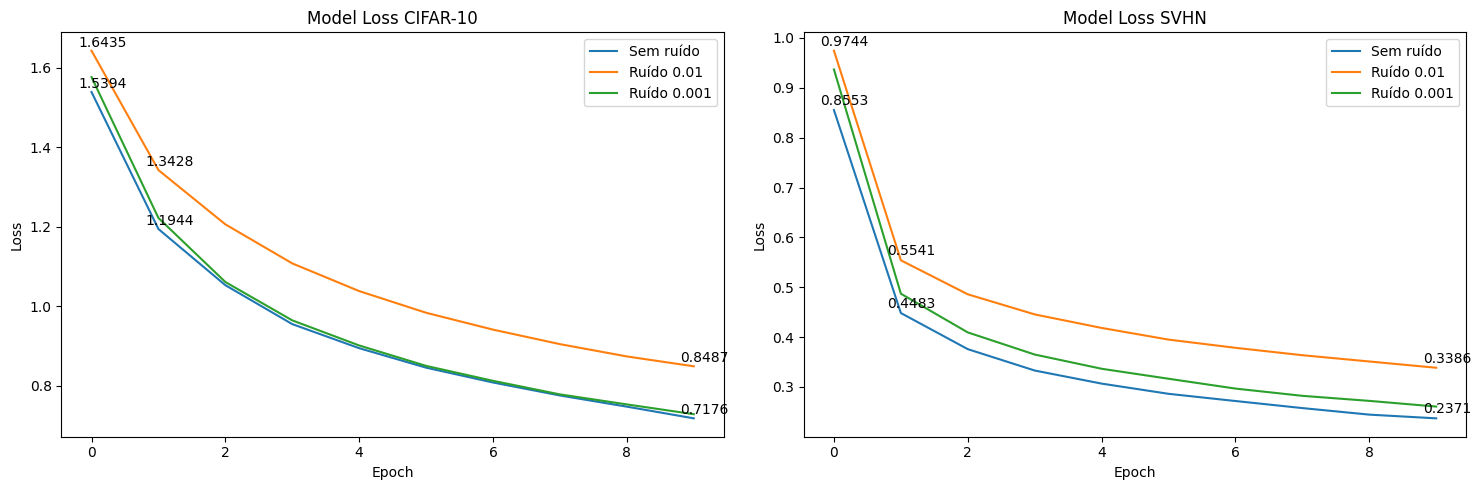

In [ ]:
# Plotando o histórico das loss com o tempo para CIFAR-10 e SVHN lado a lado
plt.figure(figsize=(15, 5))

# Plot para CIFAR-10
plt.subplot(1, 2, 1)
plt.plot(cifar10_resultados['train']['historico'].history['loss'])
for index, data in enumerate(cifar10_resultados['train']['historico'].history['loss']):
    if index in idx_com_dados:
        plt.text(x=(index-0.2) , y=data+0.01 , s=f"{data:.4f}" , fontdict=dict(fontsize=10))
plt.plot(cifar10_resultados['train_noise_001']['historico'].history['loss'])
for index, data in enumerate(cifar10_resultados['train_noise_001']['historico'].history['loss']):
    if index in idx_com_dados:
        plt.text(x=(index-0.2) , y=data+0.01 , s=f"{data:.4f}" , fontdict=dict(fontsize=10))
plt.plot(cifar10_resultados['train_noise_0001']['historico'].history['loss'])
plt.title('Model Loss CIFAR-10')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Sem ruído', 'Ruído 0.01', 'Ruído 0.001'], loc='upper right')

# Plot para SVHN
plt.subplot(1, 2, 2)
# Ajuste dos índices idx_com_dados para SVHN, se necessário
# (os índices podem ser diferentes dependendo do número de épocas)
# Supondo que idx_com_dados já está ajustado para SVHN
plt.plot(svhn_resultados['train']['historico'].history['loss'])
for index, data in enumerate(svhn_resultados['train']['historico'].history['loss']):
    if index in idx_com_dados:
        plt.text(x=(index-0.2) , y=data+0.01 , s=f"{data:.4f}" , fontdict=dict(fontsize=10))
plt.plot(svhn_resultados['train_noise_001']['historico'].history['loss'])
for index, data in enumerate(svhn_resultados['train_noise_001']['historico'].history['loss']):
    if index in idx_com_dados:
        plt.text(x=(index-0.2) , y=data+0.01 , s=f"{data:.4f}" , fontdict=dict(fontsize=10))
plt.plot(svhn_resultados['train_noise_0001']['historico'].history['loss'])
plt.title('Model Loss SVHN')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Sem ruído', 'Ruído 0.01', 'Ruído 0.001'], loc='upper right')

plt.tight_layout()
plt.show()


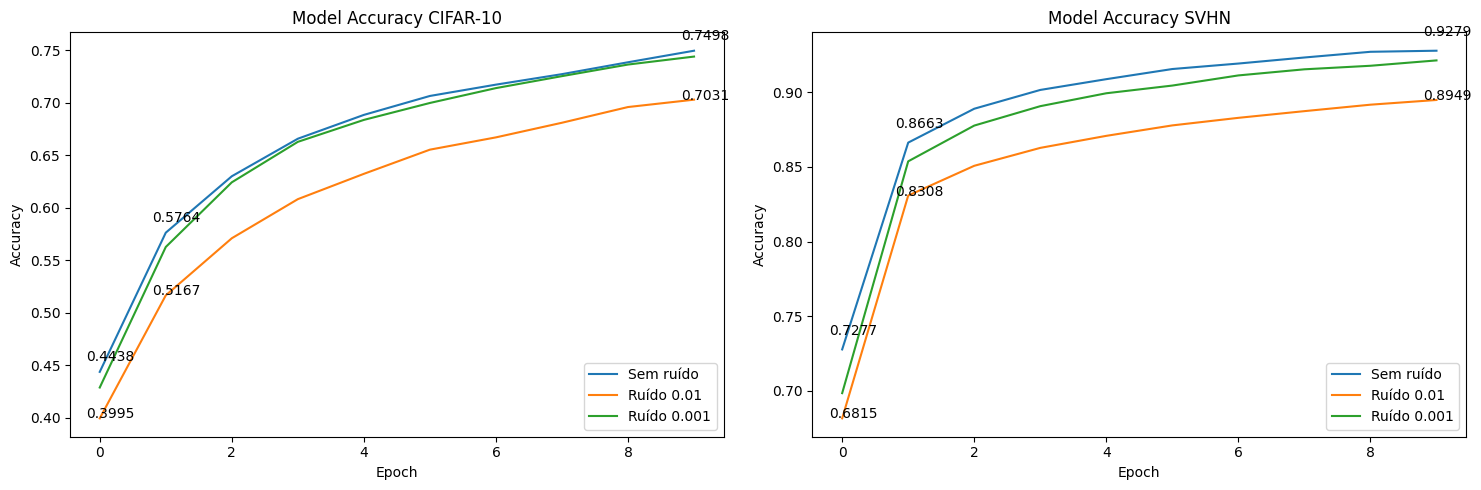

In [ ]:
# Plotando o histórico das acurácias com o tempo para CIFAR-10 e SVHN lado a lado
plt.figure(figsize=(15, 5))

# Plot para CIFAR-10
plt.subplot(1, 2, 1)
plt.plot(cifar10_resultados['train']['historico'].history['accuracy'])
for index, data in enumerate(cifar10_resultados['train']['historico'].history['accuracy']):
    if index in idx_com_dados:
        plt.text(x=(index-0.2) , y=data+0.01 , s=f"{data:.4f}" , fontdict=dict(fontsize=10))
plt.plot(cifar10_resultados['train_noise_001']['historico'].history['accuracy'])
for index, data in enumerate(cifar10_resultados['train_noise_001']['historico'].history['accuracy']):
    if index in idx_com_dados:
        plt.text(x=(index-0.2) , y=data , s=f"{data:.4f}" , fontdict=dict(fontsize=10))
plt.plot(cifar10_resultados['train_noise_0001']['historico'].history['accuracy'])
plt.title('Model Accuracy CIFAR-10')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Sem ruído', 'Ruído 0.01', 'Ruído 0.001'], loc='lower right')

# Plot para SVHN
plt.subplot(1, 2, 2)
# Ajuste dos índices idx_com_dados para SVHN, se necessário
# (os índices podem ser diferentes dependendo do número de épocas)
# Supondo que idx_com_dados já está ajustado para SVHN
plt.plot(svhn_resultados['train']['historico'].history['accuracy'])
for index, data in enumerate(svhn_resultados['train']['historico'].history['accuracy']):
    if index in idx_com_dados:
        plt.text(x=(index-0.2) , y=data+0.01 , s=f"{data:.4f}" , fontdict=dict(fontsize=10))
plt.plot(svhn_resultados['train_noise_001']['historico'].history['accuracy'])
for index, data in enumerate(svhn_resultados['train_noise_001']['historico'].history['accuracy']):
    if index in idx_com_dados:
        plt.text(x=(index-0.2) , y=data , s=f"{data:.4f}" , fontdict=dict(fontsize=10))
plt.plot(svhn_resultados['train_noise_0001']['historico'].history['accuracy'])
plt.title('Model Accuracy SVHN')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Sem ruído', 'Ruído 0.01', 'Ruído 0.001'], loc='lower right')

plt.tight_layout()
plt.show()


Pode-se notar pelas curvas acima que a adição de ruídos impacta no processo de aprendizado dos modelos e na sua capacidade preditiva e generalização dos resultados.

# 3 Resultados e Percepções

Agora, vamos tentar entender os impactos do ruído na acurácia dos modelos
avaliando a performance dos modelos nas diferentes variações das bases de dados.

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score

def calcular_matriz_accuracy(resultados, y_test):
    """
    Calcula a matriz de acurácia para um conjunto de resultados e labels verdadeiros.

    Args:
    - resultados (dict): Dicionário contendo os resultados do modelo para um conjunto de dados.
    - y_test (array): Vetor de labels verdadeiros para o conjunto de dados.

    Returns:
    - matriz_accuracy (numpy array): Matriz de acurácia para o conjunto de dados.
    """

    # Inicialize uma matriz para armazenar os resultados
    matriz_accuracy = []

    # Obtenha as chaves dos dados de teste
    keys_teste = list(resultados['train'].keys())[1:]  # Ignorar a chave 'historico'

    # Itere sobre as chaves dos dados de treinamento
    for treino in resultados.keys():
        # Crie uma lista para armazenar as métricas accuracy_score para esta combinação
        lista_accuracy = []

        # Para cada chave dos dados de teste
        for teste in keys_teste:
            # Calcule a accuracy_score entre os valores preditos e os valores verdadeiros
            acc = accuracy_score(resultados[treino][teste], y_test)
            # Adicione a accuracy_score à lista
            lista_accuracy.append(acc)

        # Adicione a lista de accuracy_score para esta combinação à matriz
        matriz_accuracy.append(lista_accuracy)

    # Converta a matriz para um numpy array para facilitar a manipulação
    matriz_accuracy = np.array(matriz_accuracy)

    return matriz_accuracy

# Exemplo de uso para CIFAR-10
matriz_accuracy_cifar10 = calcular_matriz_accuracy(cifar10_resultados, cifar10_y_test)
print("Matriz de Accuracy Score para CIFAR-10:")
print(matriz_accuracy_cifar10)

# Exemplo de uso para SVHN
matriz_accuracy_svhn = calcular_matriz_accuracy(svhn_resultados, svhn_y_test)
print("\nMatriz de Accuracy Score para SVHN:")
print(matriz_accuracy_svhn)


Matriz de Accuracy Score para CIFAR-10:
[[0.7054 0.6919 0.4875]
 [0.6921 0.6891 0.58  ]
 [0.6523 0.6582 0.6507]]

Matriz de Accuracy Score para SVHN:
[[0.90450215 0.89436079 0.78391979]
 [0.89620467 0.89128765 0.83024739]
 [0.87519207 0.8741933  0.85813614]]


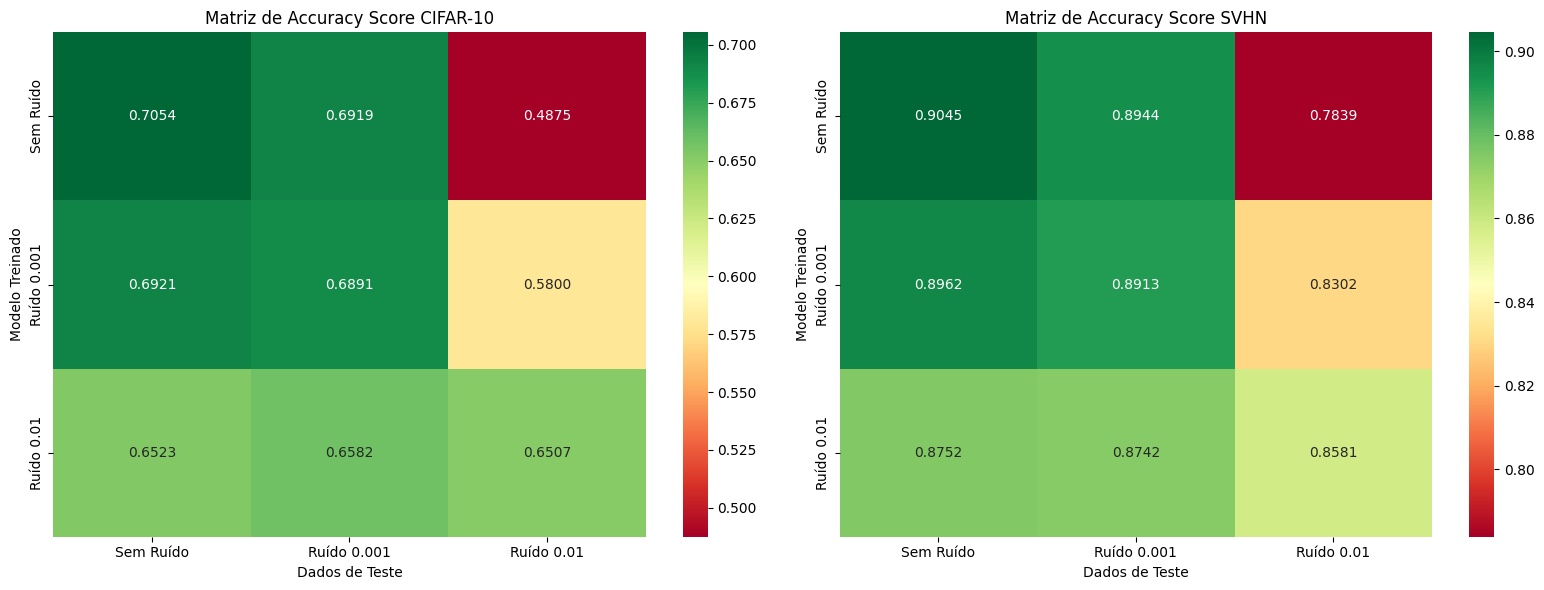

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Defina os rótulos das linhas e das colunas
row_labels = ['Sem Ruído', 'Ruído 0.001', 'Ruído 0.01']  # Coloca o treino sem ruído na primeira linha
col_labels = ['Sem Ruído', 'Ruído 0.001', 'Ruído 0.01']  # Coloca o dado com ruído 0.01 na última coluna

# Crie o heatmap para CIFAR-10
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)  # subplot com 1 linha, 2 colunas, posição 1
sns.heatmap(matriz_accuracy_cifar10, annot=True, cmap='RdYlGn', fmt=".4f", xticklabels=col_labels, yticklabels=row_labels)
plt.xlabel('Dados de Teste')
plt.ylabel('Modelo Treinado')
plt.title('Matriz de Accuracy Score CIFAR-10')

# Crie o heatmap para SVHN
plt.subplot(1, 2, 2)  # subplot com 1 linha, 2 colunas, posição 2
sns.heatmap(matriz_accuracy_svhn, annot=True, cmap='RdYlGn', fmt=".4f", xticklabels=col_labels, yticklabels=row_labels)
plt.xlabel('Dados de Teste')
plt.ylabel('Modelo Treinado')
plt.title('Matriz de Accuracy Score SVHN')

plt.tight_layout()  # Para ajustar os subplots
plt.show()


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_true, y_pred, title, ax):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', cbar=False, ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

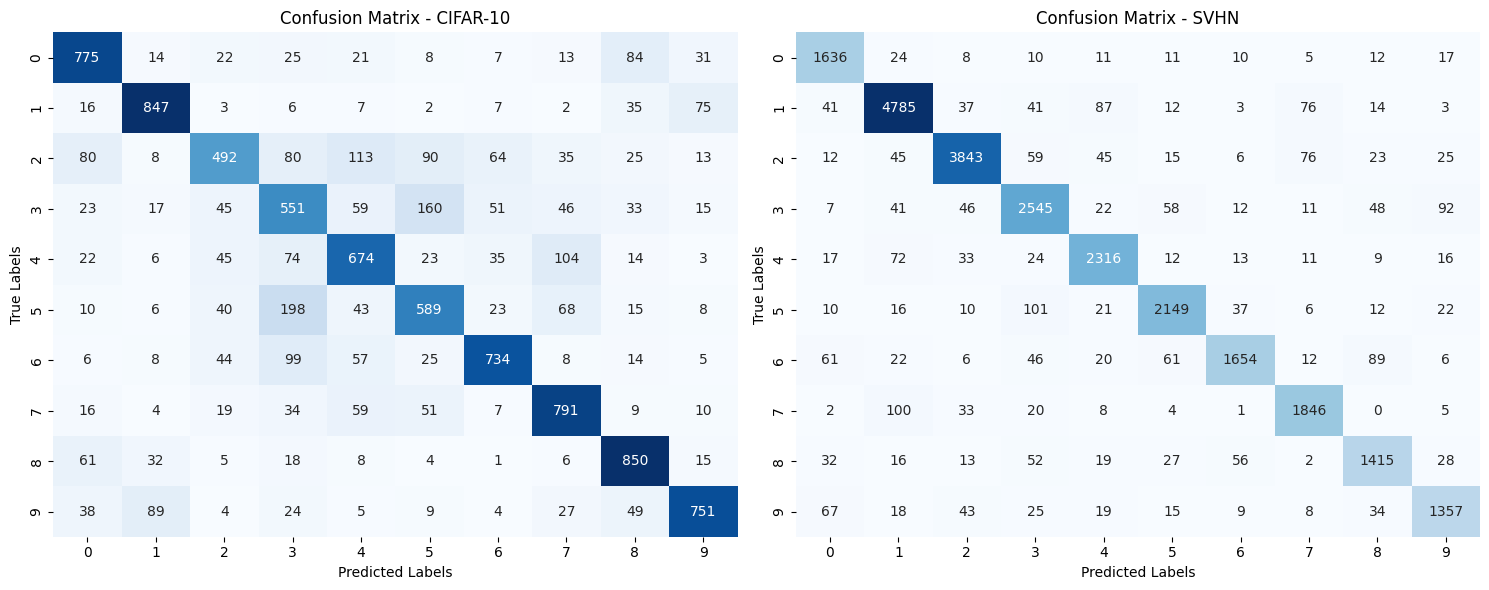

In [ ]:
# Crie uma figura com dois subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# Para CIFAR-10
y_pred_cifar10 = cifar10_resultados['train']['y_pred_0']  # Escolha o conjunto de dados desejado
plot_confusion_matrix(cifar10_y_test, y_pred_cifar10, 'Confusion Matrix - CIFAR-10', axs[0])

# Para SVHN
y_pred_svhn = svhn_resultados['train']['y_pred_0']  # Escolha o conjunto de dados desejado
plot_confusion_matrix(svhn_y_test, y_pred_svhn, 'Confusion Matrix - SVHN', axs[1])

plt.tight_layout()
plt.show()


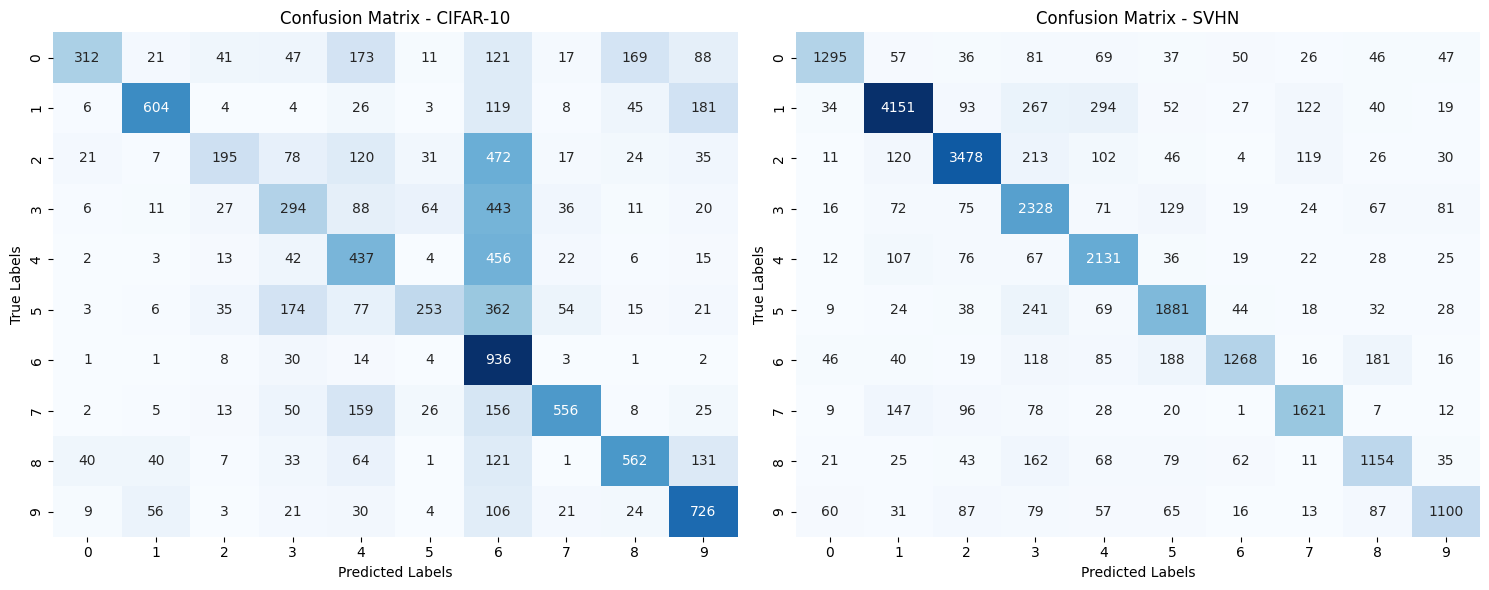

In [ ]:
# Crie uma figura com dois subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# Para CIFAR-10
y_pred_cifar10 = cifar10_resultados['train']['y_pred_2']  # Escolha o conjunto de dados desejado
plot_confusion_matrix(cifar10_y_test, y_pred_cifar10, 'Confusion Matrix - CIFAR-10', axs[0])

# Para SVHN
y_pred_svhn = svhn_resultados['train']['y_pred_2']  # Escolha o conjunto de dados desejado
plot_confusion_matrix(svhn_y_test, y_pred_svhn, 'Confusion Matrix - SVHN', axs[1])

plt.tight_layout()
plt.show()


Após analisar os resultados, algumas observações importantes se destacam.
Podendo-se resumir em dois pontos principais:

i) A presença de ruído nos dados torna o problema de aprendizado mais complexo, dificultando a capacidade do modelo de aprender com precisão em conjuntos de dados ruidosos;


ii) Quando um modelo é exposto a dados bastante diferentes dos de seu
treinamento (e.g. modelo de treino sem ruído avaliado na base de teste com bastante ruído) sua acurácia é impactada.



O comportamento geral dos modelos foi semelhante nas duas bases de dados, pode-se observar isso pelo padrão de cores das matrizes de acurácia e matrizes de confusão. A performance média foi maior na base de números de casas, conjunto de dados semelhante aos que a arquitetura Lenet se proprunha a resolver quando foi desenvolvida.


Cada modelo apresenta seu melhor desempenho quando testado no conjunto de dados
 sem ruído e o pior no conjunto de ruído mais elevado. O que demonstra o aumento da dificuldade na tarefa de treinamento com a inserção de ruídos.
 Essa característica é visualizada com mais intensidade no modelo treinado sem ruído quando testado com dados de ruído mais elevado. Isso sugere que o excesso de ruído nos dados pode prejudicar significativamente o processo de aprendizado do modelo e capacidade de generalizar resultados.

Outro aspecto notável é a estabilidade do modelo treinado com ruído mais alto ($\sigma^2 = 0.01$), que produziu resultados consistentes, de valores próximos em todas as configurações de teste, embora com a menor acurácia geral.


O modelo treinado com ruído moderado ($\sigma^2=0.001$) teve um desempenho intermediário, porém apresentando resultados satisfatórios em conjuntos de dados sem ruído ou com ruído baixo, e se saindo melhor do que o modelo treinado sem ruído na base de maior variância. O que demonstra um ganho de performance para o caso extremo com a inserção cautelosa de ruído.


Essas descobertas ressaltam o trade-off associado à introdução de ruído nos dados durante o treinamento do modelo. Embora o ruído possa tornar a tarefa de aprendizado mais complexa e prejudicar o desempenho se aplicado em excesso, em quantidades moderadas pode simular condições realistas e aumentar a capacidade de generalização do modelo. Apesar de não alcançar a maior métrica de desempenho, o modelo treinado com ruído moderado pode ser a opção mais prática e útil em cenários semelhantes às aplicações do mundo real, onde o hardware para captura de imagens não é padronizado.

Essas conclusões destacam a importância de considerar o nível de ruído nos dados durante o treinamento do modelo e ressaltam a necessidade de estratégias eficazes para lidar com o ruído e maximizar o desempenho do modelo em uma variedade de condições.

# 4 Sugestões de leitura e referências


É de conhecimento da área de RNs que a adição de rúido na base de treinamento pode gerar uma resultado positivo na performance de um modelo, especialmente quando o conjunto de treinamento é pequeno, pois aumenta a capacidade do modelo de generalizar resultados. Seguem algumas sugestões para aprofundamento no tema:
* [DATA AUGMENTATION IN TRAINING CNNS:
INJECTING NOISE TO IMAGES](https://openreview.net/pdf?id=SkeKtyHYPS)
* [Train Neural Networks With Noise to Reduce Overfitting](https://machinelearningmastery.com/train-neural-networks-with-noise-to-reduce-overfitting/)
* [Série sobre redes neurais Youtube Statquest](https://www.youtube.com/watch?v=zxagGtF9MeU&list=PLblh5JKOoLUIxGDQs4LFFD--41Vzf-ME1&pp=iAQB)
* [Paper: Deep Convolutional Neural Networks and Noisy
Images](https://sites.icmc.usp.br/moacir/papers/Nazare_CIARP2017_DNN-Noise.pdf)

Entretanto não há um consenso de qual é a quantidade adequada de ruído que deve ser adicionado para um bom resultado, o ideal é testar diferentes distribuições e em diferentes quantidades.